# DS Tuc A Flare Detection Analysis

TESSデータを用いたDS Tuc Aのフレア検出と解析

In [1]:
import os
import re
import sys
from pathlib import Path

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# プロジェクトルートを設定
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name in ['notebooks', 'src']:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))
from src.flarepy_DS_Tuc_A import FlareDetector_DS_Tuc_A

## データ読み込み（全セクター）

In [2]:
# データフォルダのパス
folder_path = PROJECT_ROOT / "data" / "TESS" / "DS_Tuc_A"

# 全FITSファイルを読み込み
file_list = sorted(folder_path.glob("*.fits"))
print(f"Found {len(file_list)} FITS files")

# 各セクターのdetectorを作成
detectors = {}
for file_path in file_list:
    match = re.search(r'-s(\d{4})-', file_path.name)
    if match:
        sector = f"s{match.group(1)}"
        key = f"detector_{sector}"
        detectors[key] = FlareDetector_DS_Tuc_A(file=str(file_path), process_data=True)
        print(f"Loaded {sector}: {detectors[key].flare_number} flares detected")

print(f"\nTotal detectors: {len(detectors)}")

Found 5 FITS files
Loaded s0001: 6 flares detected
Loaded s0027: 9 flares detected
Loaded s0028: 10 flares detected
Loaded s0067: 4 flares detected
Loaded s0068: 8 flares detected

Total detectors: 5


## 結果サマリー

In [3]:
sum_flare_number = sum(d.flare_number for d in detectors.values())
sum_obs_time = sum(d.precise_obs_time for d in detectors.values())

print(f"総フレア数: {sum_flare_number}")
print(f"総観測時間: {sum_obs_time:.2f} days")
if sum_obs_time > 0:
    print(f"平均フレア頻度: {sum_flare_number / sum_obs_time:.2f} flares/day")

総フレア数: 37
総観測時間: 111.03 days
平均フレア頻度: 0.33 flares/day


## 可視化

### ライトカーブ

/Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/src/base_flare_detector.py:1064: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(loc="upper right", fontsize=11)


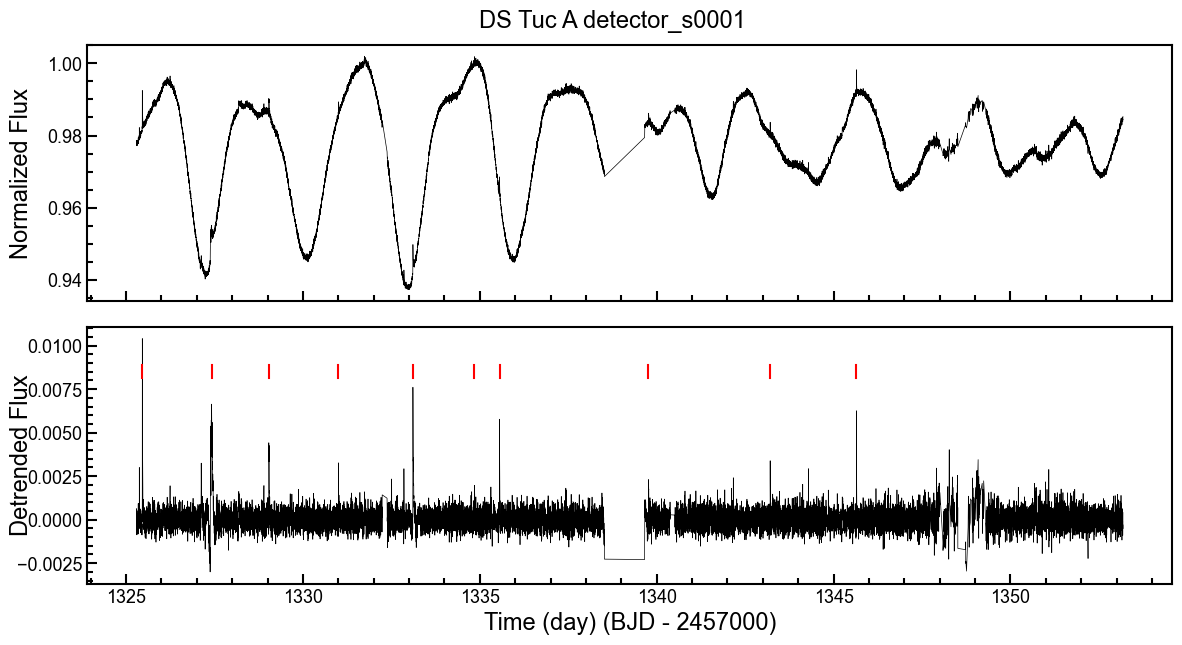

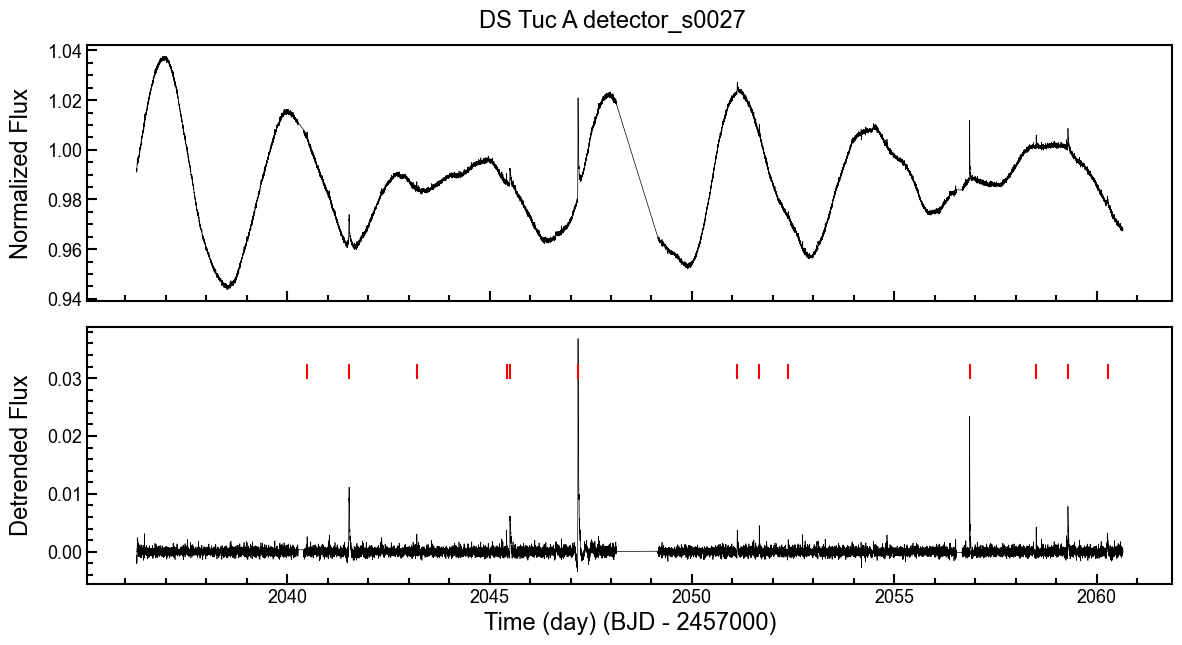

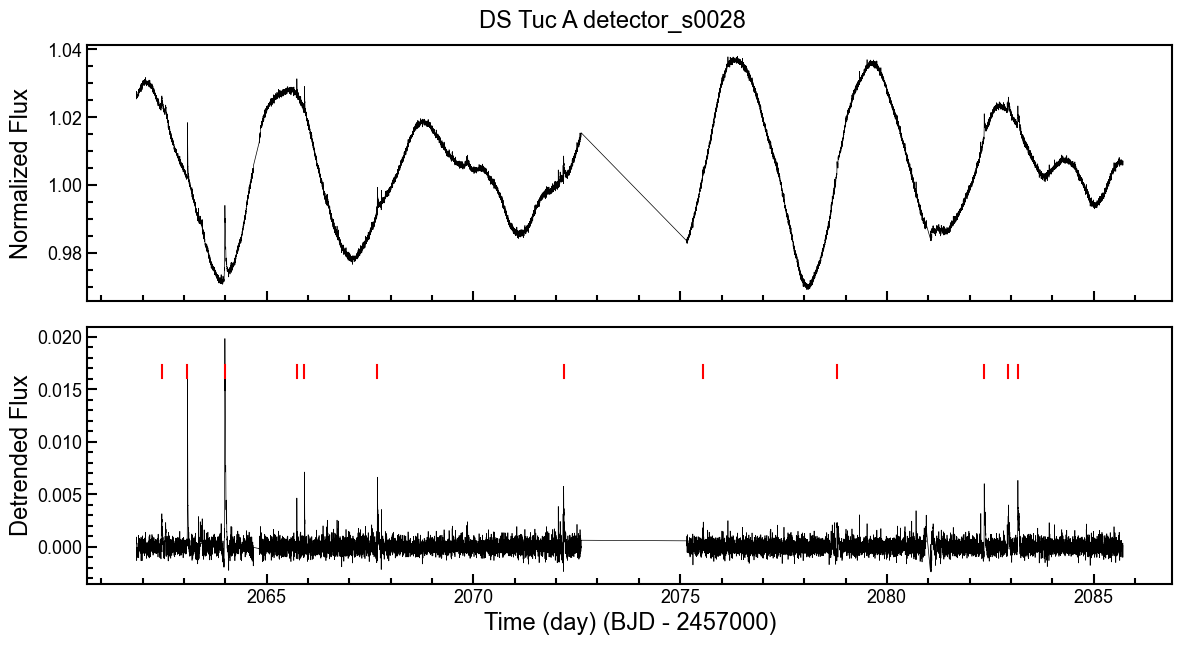

In [4]:
# 各セクターのライトカーブをプロット
for name, detector in list(detectors.items())[:3]:
    detector.plt_flare(title=f"DS Tuc A {name}")

### 周期推定（ガウスフィッティング）

In [5]:
# 代表的なセクターで周期推定（診断プロット付き）
sample_detector = list(detectors.values())[0]
sample_detector.rotation_period(show_plot=True)

print(f"\n推定周期: {sample_detector.per:.4f} (+{sample_detector.per_err_plus:.4f} / -{sample_detector.per_err_minus:.4f}) days")


推定周期: 2.8523 (+0.1598 / -0.1598) days


### エネルギー分布

In [6]:
# 各セクターのエネルギー分布
for detector in list(detectors.values())[:3]:
    detector.plot_energy()

## 統計分析（クラス変数）

In [7]:
# 時間と振幅の相関
fig = px.scatter(
    x=FlareDetector_DS_Tuc_A.array_observation_time,
    y=FlareDetector_DS_Tuc_A.array_amplitude,
    title="観測時間と光度変動振幅の関係",
    labels={"x": "Observation Time (BJD)", "y": "Amplitude"}
)
fig.show()

In [8]:
# 周期とフレア頻度の相関
fig = px.scatter(
    x=FlareDetector_DS_Tuc_A.array_per,
    y=FlareDetector_DS_Tuc_A.array_flare_ratio,
    title="自転周期とフレア頻度の関係",
    labels={"x": "Period (days)", "y": "Flare Rate (flares/day)"}
)
fig.show()

## 論文用図表出力

/Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/src/base_flare_detector.py:1064: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



保存しました: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/outputs/DS_Tuc_A_lightcurve.pdf


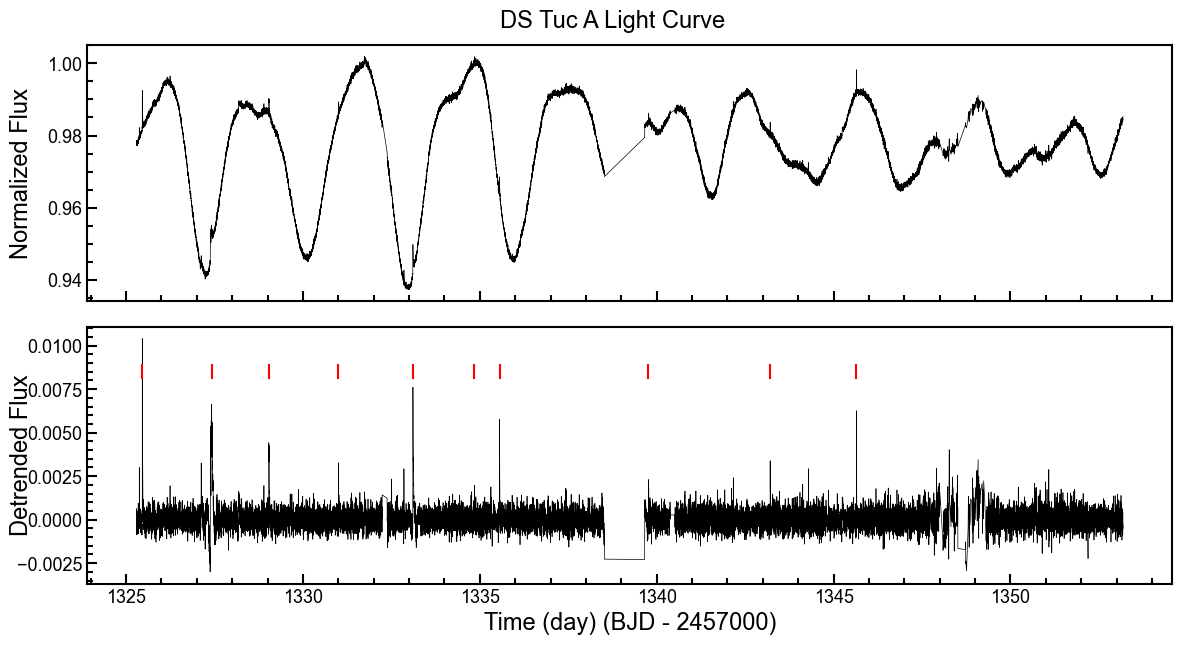

In [9]:
import matplotlib.pyplot as plt

# 論文品質の設定
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# 代表的なセクターの高品質プロット
sample = list(detectors.values())[0]
sample.plt_flare(
    title="DS Tuc A Light Curve",
    save_path=str(PROJECT_ROOT / "outputs" / "DS_Tuc_A_lightcurve.pdf")
)